In [2]:
import os
os.chdir("..")

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from src.models import prepare_ml_data, train_models

In [ ]:
df = pd.read_csv("data/processed/features_final.csv")

In [5]:
X, y, df_prep = prepare_ml_data(df)

In [6]:
# Train models
results, scaler = train_models(X, y)

In [ ]:
# Evaluate
for name, res in results.items():
    print(f"{name}: MSE={res['mse']:.6f}, R²={res['r2']:.4f}")

# Choose best model (lowest MSE)
best_model_name = min(results, key=lambda k: results[k]["mse"])
best_model = results[best_model_name]["model"]
print(f"\n Best model: {best_model_name}")

LinearRegression: MSE=0.000526, R²=0.0052
RandomForest: MSE=0.000544, R²=-0.0278
MLP: MSE=0.000821, R²=-0.5520

 Best model: LinearRegression


In [ ]:
df_prep["predicted_return"] = np.nan
df_prep.loc[df_prep.index[-len(X):], "predicted_return"] = best_model.predict(scaler.transform(X))

df_prep[["Date", "Ticker", "predicted_return"]].head()

,Date,Ticker,predicted_return
0,2020-03-13,AAPL,-0.000311
1,2020-03-13,ADBE,-0.005250
2,2020-03-13,AMZN,-0.000815
3,2020-03-13,CSCO,-0.001695
4,2020-03-13,DIS,-0.001447


In [9]:
df_prep[["Date", "Ticker", "predicted_return"]].tail()

,Date,Ticker,predicted_return
24155,2024-12-30,PYPL,0.001907
24156,2024-12-30,T,0.000854
24157,2024-12-30,TSLA,0.007457
24158,2024-12-30,UNH,0.001662
24159,2024-12-30,V,0.000836


In [10]:
df_prep.to_csv("data/processed/predicted_returns.csv", index=False)

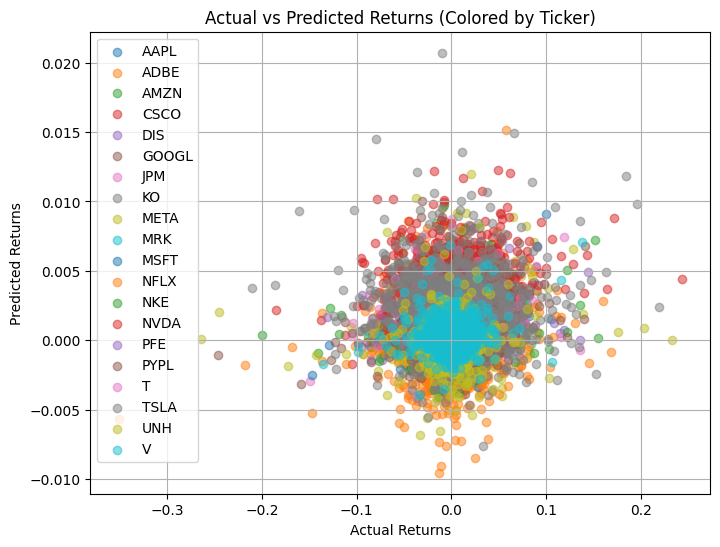

In [16]:
test_df = df_prep.dropna(subset=["target_return", "predicted_return"]).copy()

plt.figure(figsize=(8,6))
for ticker in test_df["Ticker"].unique():
    sub = test_df[test_df["Ticker"] == ticker]
    plt.scatter(
        sub["target_return"], 
        sub["predicted_return"], 
        alpha=0.5, 
        label=ticker
    )

plt.xlabel("Actual Returns")
plt.ylabel("Predicted Returns")
plt.title("Actual vs Predicted Returns (Colored by Ticker)")
plt.legend()
plt.grid(True)
plt.show()

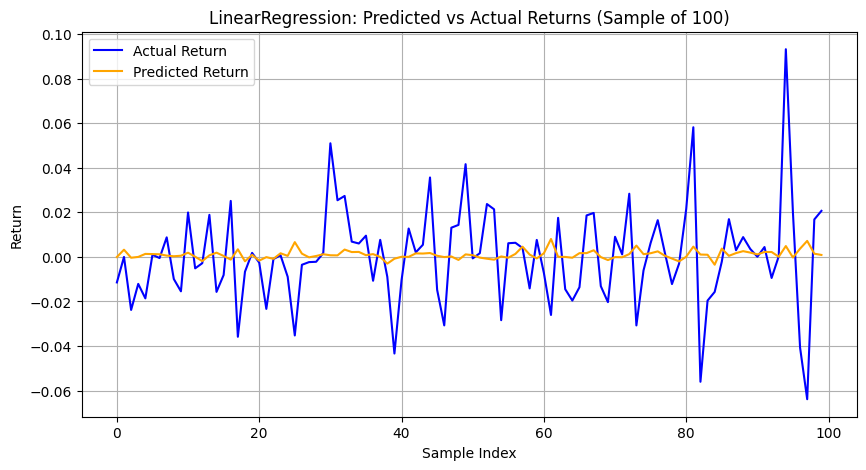

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler().fit(X_train)
y_pred = best_model.predict(scaler.transform(X_test))

comparison_df = pd.DataFrame({
    "Actual_Return": y_test,
    "Predicted_Return": y_pred
}).reset_index(drop=True)

plt.figure(figsize=(10,5))
plt.plot(comparison_df["Actual_Return"].values[:100], label="Actual Return", color="blue")
plt.plot(comparison_df["Predicted_Return"].values[:100], label="Predicted Return", color="orange")
plt.title(f"{best_model_name}: Predicted vs Actual Returns (Sample of 100)")
plt.xlabel("Sample Index")
plt.ylabel("Return")
plt.legend()
plt.grid(True)
plt.show()


In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler().fit(X_train)
y_pred = best_model.predict(scaler.transform(X_test))

test_idx = y_test.index  
comparison_df = df_prep.loc[test_idx, ["Date", "Ticker"]].copy()
comparison_df["Actual_Return"] = y_test.values
comparison_df["Predicted_Return"] = y_pred
comparison_df = comparison_df.sort_values(["Ticker", "Date"])
comparison_df.head()

,Date,Ticker,Actual_Return,Predicted_Return
180,2020-03-26,AAPL,-0.041402,0.002251
200,2020-03-27,AAPL,0.028538,0.005899
280,2020-04-02,AAPL,-0.014371,0.002251
300,2020-04-03,AAPL,0.087237,0.004161
360,2020-04-08,AAPL,0.007216,0.003163


In [21]:
fig = px.line(
    comparison_df,
    x="Date",
    y=["Actual_Return", "Predicted_Return"],
    color_discrete_map={"Actual_Return": "blue", "Predicted_Return": "orange"},
    facet_col="Ticker",  # separate subplots per ticker (optional)
    facet_col_wrap=3,
    title="Actual vs Predicted Returns by Ticker (Interactive)",
)
fig.update_traces(line=dict(width=1.2))
fig.update_layout(
    hovermode="x unified",
    showlegend=True,
    height=800,
    template="plotly_white"
)
fig.show()